# medMNIST exploration

In [29]:
import medmnist
print(medmnist.__version__)

3.0.2


In [30]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [31]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [32]:
# show my GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# check if GPU is available
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / (1024 ** 3):.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved(0) / (1024 ** 3):.2f} GB")
else:
    print("No GPU available, using CPU instead.")


Using device: cuda
GPU name: NVIDIA GeForce GTX 1080 Ti
GPU memory allocated: 0.11 GB
GPU memory cached: 0.15 GB


In [33]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4708
Number of test samples: 624


In [34]:
print(type(train_dataset[0]))
print(len(train_dataset[0]))
image, label = train_dataset[0]
print(type(image))


<class 'tuple'>
2
<class 'PIL.Image.Image'>


In [35]:
from matplotlib import pyplot as plt

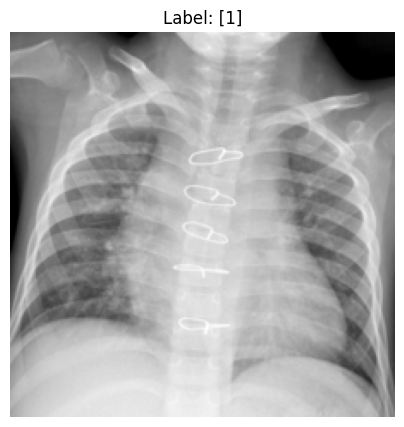

In [36]:
# print 1st 10 samples
for i in range(1):
    image, label = train_dataset[i]
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()

In [37]:
# number of samples of each class
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)
print(f"Number of positive samples: {postive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 3494
Number of negative samples: 1214


In [38]:
info =INFO['pneumoniamnist']
print(info)
n_channels = info['n_channels']
n_classes = info['label']
print("Number of channels:",n_channels)
print("Number of classes",n_classes)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [39]:
dataiter = iter(train_dataset)
image, label = next(dataiter)
print(image.size)
print(label.shape)

(224, 224)
(1,)


### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS

### Data transformations
* Transform to tensor
* Normalize

### Create the dataloaders


In [52]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

dataiter = iter(train_loader)
image, label = next(dataiter)
print(image.shape)
print(label.shape)



Train dataset size: 4708
Test dataset size: 624
Validation dataset size: 524
torch.Size([32, 1, 224, 224])
torch.Size([32, 1])


### Create the SequentialNN classifier class

In [53]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 224x224 -> 112x112
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 112x112 -> 56x56
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 56x56 -> 28x28
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # Calculate the flattened size dynamically (or pre-calculate)
        # After 4 pooling layers (2x2 stride), the size is 224 / (2^4) = 224 / 16 = 14
        # Flattened size = channels * height * width = 256 * 14 * 14
        self.flattened_size = 256 * 14 * 14

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x) # Output raw logits
        return x


In [54]:
# Instantiate the model and move it to the device
model = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)
print(model)

# Optional: Print model summary (requires torchsummary)
from torchsummary import summary
summary(model, (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu_fc): ReLU()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)
-----------------------------

In [44]:
import torchmetrics

In [45]:
# Loss function
# BCEWithLogitsLoss combines Sigmoid layer and BCELoss in one single class.
# It's more numerically stable than using a plain Sigmoid followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Metrics using torchmetrics (more robust than manual calculation)
# We need 'BinaryAccuracy' and potentially 'BinaryAUROC' for binary tasks.
# Make sure to move metrics objects to the correct device.
train_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_auc_metric = torchmetrics.AUROC(task="binary").to(device)
roc_metric = torchmetrics.ROC(task="binary").to(device)

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, accuracy_metric):
    model.train()  # Set model to training mode (enables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset() # Reset metric at the start of epoch

    # Use tqdm for a progress bar
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        # Labels need to be float and match the output shape for BCEWithLogitsLoss
        # Original labels might be Long, convert to Float.
        # The output of the model is [batch_size, 1], labels should be [batch_size, 1] or [batch_size]
        #labels = labels.float().unsqueeze(1).to(device) # Add dimension if necessary
        labels = labels.float().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # Shape: [batch_size, 1] (logits)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0) # loss.item() is avg loss per batch

        # Update metrics (expects probabilities or logits)
        # Pass outputs directly (logits) or torch.sigmoid(outputs) (probabilities)
        accuracy_metric.update(outputs, labels.int()) # Accuracy metric often needs integer labels

        # Update progress bar description
        if (i + 1) % 50 == 0 or i == len(loader) - 1:
             progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    print(f"Epoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc



In [58]:
def validate_one_epoch(model, loader, criterion, device, accuracy_metric, auc_metric, roc_metric):
    model.eval()   # Set model to evaluation mode (disables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset()
    auc_metric.reset()
    roc_metric.reset()

    progress_bar = tqdm(loader, desc="           [Validate]", leave=False)

    with torch.no_grad(): # Disable gradient calculations for validation
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device) # Ensure float and correct shape
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update metrics
            accuracy_metric.update(outputs, labels.int())
            auc_metric.update(outputs, labels.int()) # AUC metric also needs integer labels
            roc_metric.update(outputs, labels.int())

            progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item(), auc=auc_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    epoch_auc = auc_metric.compute()
    epoch_roc = roc_metric.compute() # Get ROC curve (if needed)
    print(f"         Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f}")
    return epoch_loss, epoch_acc, epoch_auc, epoch_roc



In [63]:
def test_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    # Use fresh metric instances for testing
    test_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
    test_auc_metric = torchmetrics.AUROC(task="binary").to(device)
    # Add other relevant metrics if needed (Precision, Recall, F1)
    test_precision_metric = torchmetrics.Precision(task="binary").to(device)
    test_recall_metric = torchmetrics.Recall(task="binary").to(device)
    test_f1_metric = torchmetrics.F1Score(task="binary").to(device)
    test_roc_metric = torchmetrics.ROC(task="binary").to(device)

    print("\nStarting Testing...")
    progress_bar = tqdm(loader, desc="[Test]", leave=False)

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update all test metrics
            int_labels = labels.int()
            test_accuracy_metric.update(outputs, int_labels)
            test_auc_metric.update(outputs, int_labels)
            test_precision_metric.update(outputs, int_labels)
            test_recall_metric.update(outputs, int_labels)
            test_f1_metric.update(outputs, int_labels)
            test_roc_metric.update(outputs, int_labels)

    test_loss = running_loss / len(loader.dataset)
    test_acc = test_accuracy_metric.compute()
    test_auc = test_auc_metric.compute()
    test_precision = test_precision_metric.compute()
    test_recall = test_recall_metric.compute()
    test_f1 = test_f1_metric.compute()
    test_roc = test_roc_metric.compute() # Get ROC curve if needed


    print("\n--- Test Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("--------------------")


    # It's good practice to clean up metric states
    test_accuracy_metric.reset()
    test_auc_metric.reset()
    test_precision_metric.reset()
    test_recall_metric.reset()
    test_f1_metric.reset()
    test_roc_metric.reset()

    return test_roc



In [ ]:
# --- Placeholder for storing history ---
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_aucs = [] # Store validation AUC
val_rocs = [] # Store validation ROC

In [61]:
# --- Main Training Execution ---
print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
    val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

    # Store metrics for plotting later
    train_losses.append(train_loss)
    train_accs.append(train_acc.item()) # Get scalar value from tensor
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())
    val_aucs.append(val_auc.item())
    val_rocs.append(val_roc) # Store ROC curve if needed

print("Training Finished!")


Starting Training...


Epoch 1 Train Loss: 0.7046 Acc: 0.2579


         Validation Loss: 0.7046 Acc: 0.2576 AUC: 0.5229


Epoch 2 Train Loss: 0.7046 Acc: 0.2579


         Validation Loss: 0.7046 Acc: 0.2576 AUC: 0.5229
Training Finished!


In [67]:
# Run testing
test_roc = test_model(model, test_loader, criterion, device)


Starting Testing...



--- Test Results ---
Test Loss: 0.6991
Test Accuracy: 0.3750
Test AUC: 0.6059
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000
--------------------


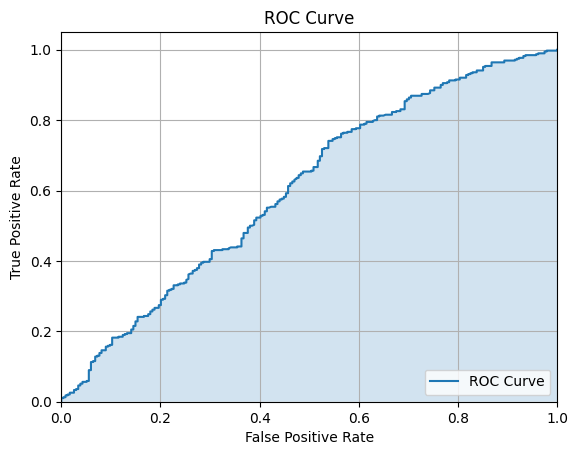

In [72]:
#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve")
plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()
